In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

# load data

In [4]:
data_dir = 'data'

In [5]:
i_sim = 1

In [6]:
data_network = pd.read_feather('%s/network.feather'%(data_dir))
data_latent = pd.read_feather('%s/latent.feather'%data_dir)
data_feature = pd.read_feather('%s/feature_%.3d.feather'%(data_dir, i_sim))

In [7]:
data_network

,row,col
0,1,5
1,1,17
2,2,3
3,2,9
4,3,2
...,...,...
15073,3998,3920
15074,4000,3401
15075,4000,3770
15076,4000,3778


In [8]:
data_feature

,X1,X2,X3,p,T,m,Y
0,-1.278402,-1.591334,0.107586,0.200836,0,5.047072,5.513204
1,0.584844,2.677987,-0.534355,0.796448,0,-5.633645,-7.744305
2,-0.119814,-0.826955,-0.077652,0.374675,0,-2.252404,-3.057043
3,-0.511675,-0.302020,1.854573,0.627250,0,-2.892201,-2.323935
4,-0.543441,-0.164204,-0.647922,0.336756,0,1.108319,1.926767
...,...,...,...,...,...,...,...
3995,-0.640696,0.294088,0.020524,0.459330,1,2.368323,3.096963
3996,-0.706795,-0.955354,0.719974,0.384359,0,-0.572982,-1.058140
3997,1.759242,0.521243,0.651477,0.812446,1,-4.426277,-4.683871
3998,-0.570883,-1.667663,-1.006388,0.164865,0,4.029649,2.853612


In [9]:
n_node = len(data_latent); n_node

4000

In [10]:
len(data_network)

15078

In [11]:
Adj = sparse.csr_matrix((
    np.full(len(data_network), True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
), shape=(n_node,n_node)).toarray()

In [12]:
G = KECENI.Graph(Adj)

In [13]:
Ys = data_feature.iloc[:,6].values
Ts = data_feature.iloc[:,4].values
Xs = data_feature.iloc[:,0:3].values

In [14]:
data = KECENI.Data(Ys, Ts, Xs, G)

# hyperparameters

In [15]:
from hyperparams import delta

# counterfactual of interest

In [16]:
i0 = 0

In [17]:
T0s_0 = np.full(n_node, 0)
T0s_1 = np.full(n_node, 1)

In [18]:
T0s_0[G.N1(i0)], T0s_1[G.N1(i0)]

(array([0, 0, 0]), array([1, 1, 1]))

In [19]:
i0s = np.array([i0])
T0s = np.array([T0s_0, T0s_1])

# groundtruth

In [20]:
from KECENI.RegressionModel import FittedRegressionModel
from KECENI.PropensityModel import FittedPropensityModel
from KECENI.CovariateModel import FittedCovariateModel

In [21]:
from true_model import mu, pi, rX

In [22]:
true_model = KECENI.Model(
    FittedRegressionModel(mu),
    FittedPropensityModel(pi),
    FittedCovariateModel(rX),
    delta
)

In [23]:
true_fit = true_model.fit(data)

In [24]:
result_true = true_fit.G_estimate(i0s, T0s, n_X=10000)

In [25]:
YTR_0, YTR_1 = result_true.reshape([2,-1])
YTR_d = YTR_1 - YTR_0

In [26]:
YTR_0, YTR_1, YTR_d

(array([-2.01232379]), array([1.99405458]), array([4.00637837]))

# estimation

In [27]:
from KECENI.RegressionModel import LinearRegressionModel
from KECENI.PropensityModel import LogisticIIDPropensityModel
from KECENI.CovariateModel import IIDCovariateModel

In [28]:
from hyperparams import summary_mu, summary_pi

In [29]:
keceni_model = KECENI.Model(
    LinearRegressionModel(summary_mu),
    LogisticIIDPropensityModel(summary_pi),
    IIDCovariateModel(bal=False),
    delta,
)

In [30]:
keceni_fit = keceni_model.fit(data, tqdm=tqdm)

fit: 100%|██████████| 4000/4000 [02:25<00:00, 27.53it/s]


## - cross-validation

In [31]:
lamdas = np.linspace(0, 20, 21)[1:]

In [32]:
result_cv = keceni_fit.cv(
    tqdm=tqdm
)

cv: 100%|██████████| 4000/4000 [02:56<00:00, 22.68it/s]


In [33]:
xs_cv, xhs_cv = result_cv.xs_xhs(lamdas)

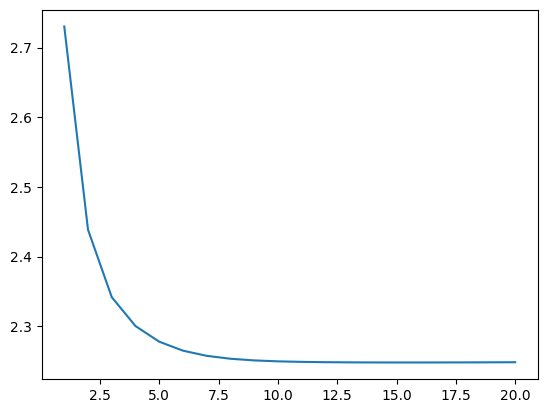

In [34]:
plt.plot(lamdas, np.mean((xs_cv-xhs_cv)**2, -1))

In [35]:
id_cv = np.argmin(np.mean((xs_cv-xhs_cv)**2, -1))
id_cv

14

In [36]:
# id_cv = 10

In [37]:
lamdas[id_cv]

15.0

## - G estimate

In [38]:
result_G = keceni_fit.G_estimate(i0s, T0s, n_X=1000)

In [39]:
YG_0, YG_1 = np.moveaxis(result_G, -1, 0)
YG_d = YG_1 - YG_0

In [40]:
YG_0, YG_1, YG_d

(-2.110523333380458, 1.8387182414535812, 3.9492415748340393)

## - KECENI

In [41]:
result_AIPW = keceni_fit.kernel_AIPW(
    i0s, T0s, tqdm=tqdm
)

AIPW: 100%|██████████| 4000/4000 [01:12<00:00, 54.89it/s]


In [42]:
YDR_0, YDR_1 = np.moveaxis(result_AIPW.est(lamdas), -1, 0)
YDR_d = YDR_1 - YDR_0

In [43]:
YDR_0[id_cv], YDR_1[id_cv], YDR_d[id_cv]

(-1.9483454819400674, 1.939008519747024, 3.8873540016870916)